# Which is the best neighborhood to open a restaurant in Mexico City?

## Introduction

<div style="text-align: justify"> Mexico City is one of the most largest and crowded cities in the world. There are almost 22 million people interacting in it. The income per capita among the "chilangos" (how people from Mexico City are called) is one of the highest in the country. The large amount of people and the good wages make Mexico City a good place to open a restaurant. Nevertheless, there are some neighborhoods not worthy to consider, and mainly this is due insecurity. In this final assignment, I considered two main variables to decide where is the best neighborhood to open a restaurant, these variables are crime index and restaurants density. Combining these two variables, I made clusters to find the equilibrium with good restaurant’s density neighborhoods and at the same time with low index crime.
</div>

## Data

<div style="text-align: justify"> 
First, I downloaded Mexico City’s neighborhoods (<a href="https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/table/">Check the info here</a>). Mexico City is divided in 16 Alcaldías which are similar to counties in U.S.. These Alcadias are divided in 1,646 neighborhoods, nevertheless, I had to make a random sample from these neighborhoods due to licence limits in the Foursquare API.Using Foursquare -and a 500m radius- I got all the venue categories, around 246 categories are in those neighborhoods, but I only found 50 realted with food services. Finally, I downloaded crime's data provided by government’s city (<a href="https://datos.cdmx.gob.mx/explore/dataset/victimas-en-carpetas-de-investigacion-pgj/table/">Check the info here</a>). There are 249 different labels for the crimes, I only used those related with robbery in any form: with and without violence; to individuals or firms, etc. After filtering there were only 15 categories, I added them to get the total robbers in the neighborhood.
</div>

### Methodology

<div style="text-align: justify"> 
To make a proper use of Foursquare API I computed the inside centroids of each neighborhood. In order to find the restaurands or food related business I used a 500m radius. Once I had all the venue categories inside this radius I cathegorized them in "food related" and "not food related". Then, I counted all the business related to food: Pizza places, bars, restaurants of any kind, etc.To find the second variable, I created a crime index which is the total number of robberies in those neighborhoods. Crime Index and Restaurants were merged and with these two variables I generated four clusters using K-NN method -these four clusters were found using the Elbow plot. Finally, from  the cluster with less crime index and with higher number of restaurants I picked the best neighborhood in the sample to open a restaurant.
</div>

#### Importing neighborhoods

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
geodata = pd.read_csv(body)
geodata.head()


,Neighborhood,lat,lon,crime index
0,10 DE ABRIL,19.448551,-99.208486,8
1,10 DE MAYO,19.433517,-99.117990,20
2,12 DE DICIEMBRE,19.329337,-99.100484,3
3,15 DE AGOSTO,19.484574,-99.107957,13
4,16 DE SEPTIEMBRE,19.402099,-99.207101,10


In [2]:
from geopy.geocoders import Nominatim
address = 'Mexico City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


In [3]:
geodata['popup']=''
for i in list(range(geodata.shape[0])):
    geodata.loc[i,'popup']=geodata.loc[i,'Neighborhood']+', crimes: '+str(geodata.loc[i,'crime index']) 

In [4]:
geodata.head()

,Neighborhood,lat,lon,crime index,popup
0,10 DE ABRIL,19.448551,-99.208486,8,"10 DE ABRIL, crimes: 8"
1,10 DE MAYO,19.433517,-99.117990,20,"10 DE MAYO, crimes: 20"
2,12 DE DICIEMBRE,19.329337,-99.100484,3,"12 DE DICIEMBRE, crimes: 3"
3,15 DE AGOSTO,19.484574,-99.107957,13,"15 DE AGOSTO, crimes: 13"
4,16 DE SEPTIEMBRE,19.402099,-99.207101,10,"16 DE SEPTIEMBRE, crimes: 10"


In [5]:
geodata.dtypes

Neighborhood     object
lat             float64
lon             float64
crime index       int64
popup            object
dtype: object

### Mexico City's map with a 100 sample points -the cricles' size and the Crime Index are proportional.

In [27]:
import folium 

# create map of Manhattan using latitude and longitude values
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=11)

geodata=geodata.sample(n=100)

# add markers to map
for lat, lng, label, rad in zip(sample['lat'], sample['lon'], sample['popup'],sample['crime index']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=rad/10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
map_cdmx

### Using Foursquare

In [101]:
CLIENT_ID = 'WMZMBR2ZPFG0T35EU4NEQCHE0TDEO3YHVZTD1GZ0FYXEW3XT' # your Foursquare ID

VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WMZMBR2ZPFG0T35EU4NEQCHE0TDEO3YHVZTD1GZ0FYXEW3XT


In [24]:
LIMIT=100

In [25]:
import requests
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
cdmx_venues = getNearbyVenues(names=geodata['Neighborhood'],
                                   latitudes=geodata['lat'],
                                   longitudes=geodata['lon']
                                  )

In [29]:
cdmx_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PRESIDENTES EJIDALES PRIMERA SECCION,19.326805,-99.128042,Don Roque Antojos Yucatecos,19.329438,-99.129015,Food & Drink Shop
1,PRESIDENTES EJIDALES PRIMERA SECCION,19.326805,-99.128042,Frody - Hospital Naval,19.326813,-99.124468,Ice Cream Shop
2,PRESIDENTES EJIDALES PRIMERA SECCION,19.326805,-99.128042,Pizzas Plaza,19.329575,-99.128316,Pizza Place
3,PRESIDENTES EJIDALES PRIMERA SECCION,19.326805,-99.128042,Flautas Nany,19.329346,-99.126346,Taco Place
4,PRESIDENTES EJIDALES PRIMERA SECCION,19.326805,-99.128042,Ara's Burger,19.329471,-99.128763,Burger Joint


In [31]:
print('There are {} uniques categories.'.format(len(cdmx_venues['Venue Category'].unique())))

There are 246 uniques categories.


In [39]:
categories=cdmx_venues['Venue Category'].unique()

### Restaurants' filter

In [51]:
cl=['Taco' in i or 
    'Food' in i or 
    'Soup' in i or
    'Pizza' in i or
    'Soup' in i or
    'Steakhouse' in i or
    'Bistro' in i or
    'Bar' in i or
    'Salad' in i or
    'BBQ' in i or
    'Sandwich' in i or 
    'Restaurant' in i for i in categories]

In [53]:
categories=categories[cl]
cdmx_venues['restaurant']=0

In [95]:
len(categories)

50

In [56]:
for i in cdmx_venues['Venue Category']:
    if i in categories:
        cdmx_venues['restaurant']=1

In [58]:
neig_rest=cdmx_venues[['Neighborhood','restaurant']].groupby('Neighborhood',as_index=False).count()

### Merging restaurants and crime index

In [61]:
data=geodata.merge(neig_rest,'left',on='Neighborhood')

In [63]:
data.fillna(0,inplace=True)

### Cluster Analysis

In [81]:
from sklearn import preprocessing
X = preprocessing.normalize(np.array(data[['restaurant','crime index']]))

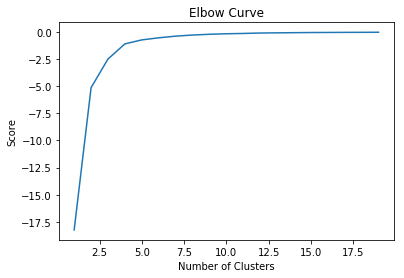

In [82]:
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### I  consider 4 clusters

In [85]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_

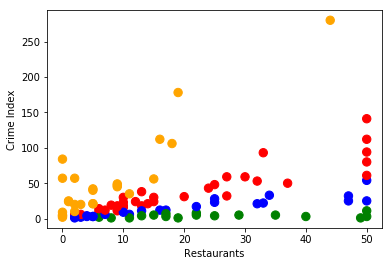

In [87]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers

colores=['red','green','blue','orange']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
f1 = data['restaurant'].values
f2 = data['crime index'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.xlabel("Restaurants")
plt.ylabel("Crime Index")

plt.show()

In [90]:
data['labels']=labels
data['labels'].replace({0:'less probable',1:'high probable',2:'probable',3:'not probable'},inplace=True)

In [92]:
data['colors']=data['labels'].replace({'less probable':'red','high probable':'green','probable':'blue','not probable':'orange'})

In [94]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, label, color in zip(data['lat'], data['lon'], data['Neighborhood'], data['labels'],data['colors']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Finding the best neighborhood to open a restaurant

In [99]:
data.loc[data['labels']=='high probable'].sort_values(by='restaurant',ascending=False).head()

,Neighborhood,lat,lon,crime index,popup,restaurant,labels,colors
0,PRESIDENTES EJIDALES PRIMERA SECCION,19.326805,-99.128042,3,"PRESIDENTES EJIDALES PRIMERA SECCION, crimes: 3",50.0,high probable,green
53,VILLA PANAMERICANA 5TA. SECCIN (U HAB),19.309220,-99.168211,11,"VILLA PANAMERICANA 5TA. SECCIN (U HAB), crimes...",50.0,high probable,green
10,XOPA (U HAB),19.360378,-99.125067,1,"XOPA (U HAB), crimes: 1",49.0,high probable,green
1,INFONAVIT CULHUACAN ZONA 3 (U HAB),19.327769,-99.118597,3,"INFONAVIT CULHUACAN ZONA 3 (U HAB), crimes: 3",40.0,high probable,green
28,FAJA DE ORO,19.465884,-99.105110,5,"FAJA DE ORO, crimes: 5",35.0,high probable,green


### Results

<div style="text-align: justify"> 
Using crime index and restaurants density I found that "Presidentes Ejidales Primera Sección" is the best neighborhood to open a restaurant. There are already 50 restaurants over there which is a good sign of the high demand for food in that area. In addition, only three robberies were registered in 2019 making this area a safe zone. 
</div>

### Discussion

<div style="text-align: justify"> 
I could make further analysis to know the client's taste and willingness to pay, with these new variables I can would estimates what kind of restaurant's type should be open, increasing the probability of succes. Unfortunately, I found several limitations. Foursquare API limits the amount of queries which has a direct impact in the accuracy of the pretictions doing the analysis just in a sample. 
</div>

### Conclusion

<div style="text-align: justify"> To decide where is the best neighborhood to open a restaurant in Mexico City, I considered two main variables: crime index and restaurants density. Combining these two variables, I made clusters to find the equilibrium between good restaurant’s density neighborhoods and  low index crime neighborhoods. I found that "Presidentes Ejidales Primera Sección" is the best neighborhood to open a restaurant bucause its restaurant's demand  and its security. 
</div>